# Question 1

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

### Load and Transform data

Transforme le fichier en array numpy de la forme (n_examples, n_features + 1 (pour le label))

In [2]:
with open('PATCH.amat') as f:
    lines = f.readlines()

X_train = np.ndarray(shape=(50000, 785), dtype=int)
for i,line in enumerate(lines):
    line = line.split(" ")
    # remove \n
    line[-1] = line[-1][:-1]
    k = 0
    for j in range(len(line)):
        if line[j] == '1.0000000e+00':
            X_train[i][k] = 1
            k += 1
        elif line[j] == '0.0000000e+00':
            X_train[i][k] = 0
            k += 1

print(X_train.shape)
print(X_train[0].shape)
print(X_train[999])

(50000, 785)
(785,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 

### Construction du CNN

Hyper parameters

In [3]:
num_epochs = 60
num_classes = 2
batch_size = 16
learning_rate = 0.001

Transfert les données de numpy à pytorch

In [4]:
# Load numpy dataset
train_size = 40000

X_valid = X_train[train_size:]
X_train = X_train[:train_size]

# separate labels
y_train = X_train[:,-1]
X_train = X_train[:,:-1]
y_valid = X_valid[:,-1]
X_valid = X_valid[:,:-1]


# Transform to torch tensors
tensor_X_train = torch.stack([torch.Tensor(i.reshape(28,28)) for i in X_train])
tensor_y_train = torch.stack([torch.Tensor([i]) for i in y_train])

tensor_X_valid = torch.stack([torch.Tensor(i.reshape(28,28)) for i in X_valid])
tensor_y_valid = torch.stack([torch.Tensor([i]) for i in y_valid])

# Transform to dataset
train_dataset = torch.utils.data.TensorDataset(tensor_X_train.unsqueeze(1),tensor_y_train)
valid_dataset = torch.utils.data.TensorDataset(tensor_X_valid.unsqueeze(1),tensor_y_valid)


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Crée le cnn

In [5]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=31):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16, momentum=0.1, track_running_stats=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  #output (16,14,14)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32, momentum=0.1, track_running_stats=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output (32,7,7)
        self.drop_out = nn.Dropout()
        # must be nn.linear(output shape of last layer ouput (channels * height * width, num classes)
        self.fc = nn.Linear(32*7*7, num_classes)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc(out)
        return out

### Entrainement

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0)

# Variable for graph
epochs = []
loss_train = []
loss_valid = []
accuracy_train = []
accuracy_valid = []

# Train the model
total_step = len(train_loader)
total_step_valid = len(valid_loader)
for epoch in range(num_epochs):
    epochs.append(epoch)
    correct = 0
    total = 0
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        epoch_loss += loss.item()

        if (i + 1) % total_step == 0:
            loss_train.append(epoch_loss / total)
            accuracy_train.append(correct / total)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f} %'
                  .format(epoch + 1, num_epochs, i + 1, total_step, epoch_loss / total, 100 * correct / total))

    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        epoch_loss = 0
        for i, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze().long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_loss += loss.item()

            if (i + 1) % total_step_valid == 0:
                loss_valid.append(epoch_loss / total)
                accuracy_valid.append(correct / total)
                print('Test on validation set: Accuracy is {:.2f} % and Loss is {:.4f}'.format(100 * correct / total,
                                                                          epoch_loss / total))

    model.train()

Epoch [1/60], Step [2500/2500], Loss: 0.0217, Accuracy: 84.97 %
Test on validation set: Accuracy is 56.78 % and Loss is 0.0622
Epoch [2/60], Step [2500/2500], Loss: 0.0157, Accuracy: 90.47 %
Test on validation set: Accuracy is 55.08 % and Loss is 0.0718
Epoch [3/60], Step [2500/2500], Loss: 0.0122, Accuracy: 92.97 %
Test on validation set: Accuracy is 74.76 % and Loss is 0.0402
Epoch [4/60], Step [2500/2500], Loss: 0.0107, Accuracy: 94.19 %
Test on validation set: Accuracy is 77.85 % and Loss is 0.0373
Epoch [5/60], Step [2500/2500], Loss: 0.0094, Accuracy: 94.95 %
Test on validation set: Accuracy is 83.62 % and Loss is 0.0277
Epoch [6/60], Step [2500/2500], Loss: 0.0086, Accuracy: 95.44 %
Test on validation set: Accuracy is 81.20 % and Loss is 0.0330
Epoch [7/60], Step [2500/2500], Loss: 0.0077, Accuracy: 95.89 %
Test on validation set: Accuracy is 80.76 % and Loss is 0.0340
Epoch [8/60], Step [2500/2500], Loss: 0.0073, Accuracy: 96.23 %
Test on validation set: Accuracy is 87.78 % and

### Visualisation de l'entrainement

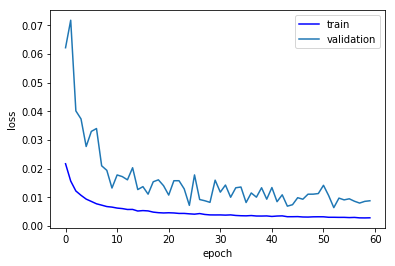

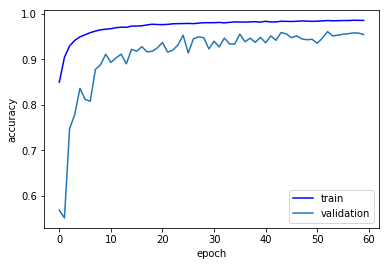

In [7]:
# Loss curve
plt.plot(epochs,loss_train, 'b', label='train')
plt.plot(epochs,loss_valid, label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# Accuracy graph
plt.plot(epochs,accuracy_train, 'b', label='train')
plt.plot(epochs,accuracy_valid, label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

### Résultat sur le test set

Load and transform test set

In [8]:
with open('PATCH_test.amat') as f:
    lines = f.readlines()
l = lines[0].split(" ")
l[-1] = l[-1][:-1]
X_test = np.ndarray(shape=(len(lines), len(l)), dtype=int)
for i,line in enumerate(lines):
    line = line.split(" ")
    line[-1] = line[-1][:-1]
    k = 0
    for j in range(len(line)):
        if line[j] == '1.000000000000000000e+00':
            X_test[i][k] = 1
            k += 1
        elif line[j] == '0.000000000000000000e+00':
            X_test[i][k] = 0
            k += 1

Test le modèle sur le test set

In [9]:
tensor_X_test = torch.stack([torch.Tensor(i.reshape(28,28)) for i in X_test])

test_dataset = torch.utils.data.TensorDataset(tensor_X_test.unsqueeze(1))

# Data loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

model.eval()
result = []
with torch.no_grad():
    for images in test_loader:
        images = images[0].to(device)
        
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        for e in predicted:
            result.append(e.item())

#Create the csv of predictions on the test set (first column is the id of examples and the second one is the prediction)
np.savetxt('Question1_Test_Result.csv', result, delimiter=',', fmt='%s')